In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch import nn

import nibabel as nib
from nilearn import maskers
from nilearn.plotting import plot_stat_map

from neurovlm.data import get_data_dir
from neurovlm.models import NeuroAutoEncoder
from neurovlm.train import Trainer, which_device
device = which_device()
data_dir = get_data_dir()

# Autoencoder

The first step is to reduce the dimensionality of the 28k MNI space neuro vector. Several work uses difumo. Instead, we use an autoencoder to map from $d=28,000$ to a $k=384$ latent space. 

## Load Neurovectors

Results from the coordinate smoothing notebook.

In [2]:
# Load NeuroConText pmids
from pathlib import Path
nc_data_dir = Path('/Users/ryanhammonds/projects/NeuroConText/data_NeuroConText')
train_pmids = np.array(list(pd.read_pickle(nc_data_dir/ "train_pmids.pkl")))
test_pmids = np.array(list(pd.read_pickle(nc_data_dir / "test_pmids.pkl")))
pmids = np.concatenate((train_pmids, test_pmids))
pmids = np.sort(pmids)

# Load neurovlm data
neurolm_dir = get_data_dir()
df = pd.read_parquet(get_data_dir() / "publications_more.parquet")
assert pd.Series(pmids).isin(df["pmid"]).all() # we have all the ids the neurocontext has and 10k more
orig = torch.load(neurolm_dir / "neuro_vectors.pt", weights_only=False).detach().cpu()

# Filter by neurocontext pmids
mask = df["pmid"].isin(pmids)
df = df[mask].copy()
df.sort_values(by="pmid", inplace=True)
df["description"] = df["description"].str.strip(" ").str.strip("\n")
df.reset_index(drop=True, inplace=True)

In [ ]:
# neuro_vectors = torch.load(
#     data_dir / "neuro_vectors.pt", weights_only=True
# ).to("cpu")
# neuro_vectors = neuro_vectors[np.array(mask)]
# torch.save(neuro_vectors, data_dir / "neuro_vectors_nc.pt")

In [3]:
neuro_vectors = torch.load(data_dir / "neuro_vectors_nc.pt")

## Training

Train an autoencoder on the neuro-vectors.

1. Encoder: Neuro-vector to low-dimensional (384) latent vector / embedding space
2. Decoder: Latent vector to produces MNI space predictions.

Training is complete in two stages:

1. Initial training anywhere neurovectors > 0
2. Additional training to shrink the size of activations closer to targets

In [4]:
# Train/test/validation split
inds = torch.arange(len(neuro_vectors))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)

### Stage 1

Training is on initially with a permissive threshold, e.g. > 0.0.

In [5]:
# Initial training
neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.0] = 1.0
trainer = Trainer(
    NeuroAutoEncoder(seed=0, dim_h0=2304, dim_h1=1152, dim_latent=768, out="logit"),
    n_epochs=20,
    batch_size=256,
    lr=1e-3,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors_bin[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors_bin[train_inds])
trainer.restore_best()

# Save
trainer.save(data_dir / "autoencoder_init_nc.pt")

# Unpack
autoencoder_init = trainer.model
# Epoch: 9,  val loss:  0.69321 (initial) -> 0.22368 (current)

Epoch: -1, val loss: 0.69316
Epoch: 0, val loss: 0.39554
Epoch: 1, val loss: 0.3667
Epoch: 2, val loss: 0.33544
Epoch: 3, val loss: 0.31867
Epoch: 4, val loss: 0.30477
Epoch: 5, val loss: 0.29105
Epoch: 6, val loss: 0.28482
Epoch: 7, val loss: 0.27306
Epoch: 8, val loss: 0.26507
Epoch: 9, val loss: 0.2579
Epoch: 10, val loss: 0.25212
Epoch: 11, val loss: 0.24392
Epoch: 12, val loss: 0.23585
Epoch: 13, val loss: 0.23042
Epoch: 14, val loss: 0.22694
Epoch: 15, val loss: 0.22361
Epoch: 16, val loss: 0.2217
Epoch: 17, val loss: 0.22038
Epoch: 18, val loss: 0.22119
Epoch: 19, val loss: 0.21759


### Stage 2

A second round of training on stricter threshold. This contracts clusters closer to the 9mm target.

In [24]:
autoencoder_init = torch.load(data_dir / "autoencoder_init_nc.pt", weights_only=False)

In [ ]:
# Additional training on tighter thresholded targets
neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.0

trainer = Trainer(
    autoencoder_init,
    n_epochs=10,
    batch_size=256,
    lr=1e-4,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors_bin[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors_bin[train_inds])

# Save
trainer.restore_best()
trainer.save(data_dir / "autoencoder_nc_soft.pt")

# Unpack
autoencoder_soft = trainer.model

Epoch: -1, val loss: 0.1574
Epoch: 0, val loss: 0.12785
Epoch: 1, val loss: 0.12611
Epoch: 2, val loss: 0.12526
Epoch: 3, val loss: 0.12466
Epoch: 4, val loss: 0.12436
Epoch: 5, val loss: 0.12413
Epoch: 6, val loss: 0.12402
Epoch: 7, val loss: 0.12402
Epoch: 8, val loss: 0.12411
Epoch: 9, val loss: 0.12422


KeyboardInterrupt: 

### Stage 3

A final round of training on probabilistic targets.

In [10]:
# Additional training on tighter thresholded targets
neuro_vectors_bin = neuro_vectors.clone()

trainer = Trainer(
    autoencoder_soft,
    #torch.load(data_dir / "autoencoder_nc_soft.pt", weights_only=False),
    n_epochs=10,
    batch_size=256,
    lr=8e-5,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors_bin[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors_bin[train_inds])

# Save
trainer.save(data_dir / "autoencoder_nc.pt")

# Unpack
autoencoder = trainer.model
# Epoch: 2, val loss: 0.020321

Epoch: -1, val loss: 0.058123
Epoch: 0, val loss: 0.020436
Epoch: 1, val loss: 0.020061
Epoch: 2, val loss: 0.019883
Epoch: 3, val loss: 0.019772
Epoch: 4, val loss: 0.019701
Epoch: 5, val loss: 0.01964
Epoch: 6, val loss: 0.0196
Epoch: 7, val loss: 0.019574
Epoch: 8, val loss: 0.019549
Epoch: 9, val loss: 0.019536


In [11]:
trainer.restore_best()
trainer.save(data_dir / "autoencoder_nc.pt")

In [12]:
# Skip above if previously trained
autoencoder = torch.load(
   data_dir / "autoencoder_nc.pt", weights_only=False
).to(device)

## Save Latent Vectors

In [14]:
# Encode neuro vectors
with torch.no_grad():
    latent_neuro = autoencoder.to('mps').encoder(neuro_vectors_bin.to("mps")).detach()
torch.save(latent_neuro, data_dir / "latent_neuro_nc.pt")

## Results

Plot an example.

In [16]:
import matplotlib.pyplot as plt

data_dir = get_data_dir()
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()

neuro_vectors_bin = neuro_vectors.clone()
#neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.0

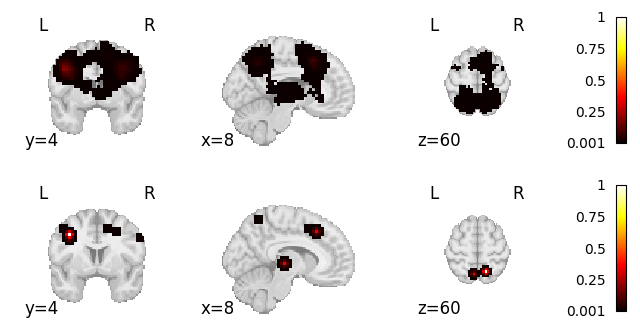

In [17]:
# Prediction
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
# idx = 2
idx = 2
out = torch.sigmoid(autoencoder.cpu()(neuro_vectors_bin[val_inds][idx]))
plot_stat_map(masker.inverse_transform(out.cpu().detach()), cut_coords=np.array([8, 4, 60]),
              cmap="hot", vmin=0, vmax=1, threshold=0.001, draw_cross=False, axes=axes[0]);

# ALEKernel target
plot_stat_map(masker.inverse_transform(neuro_vectors[val_inds][idx]), cut_coords=np.array([8, 4, 60]),
              cmap="hot", vmin=0, vmax=1, threshold=0.001, draw_cross=False, axes=axes[1]);

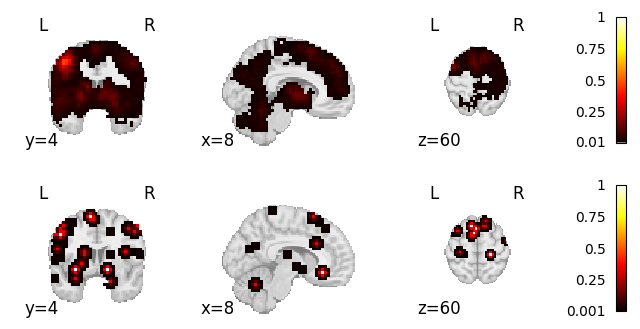

In [20]:
# Prediction
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
# idx = 2
idx = 0
out = torch.sigmoid(autoencoder.cpu()(neuro_vectors_bin[val_inds][idx]))
plot_stat_map(masker.inverse_transform(out.cpu().detach()), cut_coords=np.array([8, 4, 60]),
              cmap="hot", vmin=0, vmax=1, threshold=0.01, draw_cross=False, axes=axes[0]);

# ALEKernel target
plot_stat_map(masker.inverse_transform(neuro_vectors[val_inds][idx]), cut_coords=np.array([8, 4, 60]),
              cmap="hot", vmin=0, vmax=1, threshold=0.001, draw_cross=False, axes=axes[1]);